# PDF Image Extraction Experimental notebook

---
Author: Phillipe Cardenuto ( RECOD - UNICAMP)

email: phillipe.cardenuto@ic.unicamp.br

---

## Instructions

Before running this notebook make sure to build the pdf-content-extraction docker
```
     $ cd docker && ./build.sh
```


During the experimental setup all PDF files from the dataset will be copy to a temporary
folder, named as `pdfs`, and all files will be renamed according to the PDF-KEY in the
`pdf-image-experimental-setup.json`.

Inside the JSON file, you will find the following structure:
```
PDF-KEY: {
  'pdf-path': 'pdfs/<PDF-KEY>.pdf',
  'figures-pdf-location': {
      'fig1': {
         'figure-path': 'figures/<PDF-KEY>/fig1.<ext>',
         'figure-url' :'<link-to-original-available-figure>,
         'caption-path': 'caption/<PDF-KEY>/fig1.<ext>',
         'caption-txt': <caption-text>,
         'bbox_loc': {'p': <int>, 'x0': <int>, 'x1': <int>, 'y0': <int>, 'y1': <int>}
      }                  
  }
}
```

Warning:
-------

This notebook uses the script `run_image_extraction.sh` to extract the image from a PDF file


Make sure to have this file in the same directory of this notebook

# Requirements

You shouldn't have any issue after install the following
packages with pip
```
tqdm
scikit-image>=0.16
opencv-python>=3
imagecodecs  <-- deal with tiff images
```

# Code

In [1]:
# Import Library
from glob import glob
import shutil
import json
import subprocess
import os, pathlib
import imghdr
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map


<mark> Make sure to install the docker pdf-content-extraction</mark>.

**For this, just run the next cell**

In [2]:
%%bash
cd docker && ./build.sh

Sending build context to Docker daemon  1.482MB
Step 1/17 : FROM ubuntu:18.04
 ---> 5a214d77f5d7
Step 2/17 : ENV LANG C.UTF-8
 ---> Using cache
 ---> fa19df10f8e9
Step 3/17 : RUN apt-get update && apt-get install -y     python3.6-dev     python3-pip    poppler-utils     libsm6     libxext6     libxrender-dev     tesseract-ocr     libgl1-mesa-glx     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 9de045cae2c5
Step 4/17 : WORKDIR /work
 ---> Using cache
 ---> 47bd7760f1a6
Step 5/17 : COPY PDF-Image-Extraction PDF-Image-Extraction
 ---> Using cache
 ---> 0c0604bc02fa
Step 6/17 : COPY print_page print_page
 ---> Using cache
 ---> 67e5f3c2ee3d
Step 7/17 : COPY facade facade
 ---> Using cache
 ---> 24e70852a0bc
Step 8/17 : RUN python3 -m pip install --upgrade pip
 ---> Using cache
 ---> 500fc26e88fb
Step 9/17 : WORKDIR /work/PDF-Image-Extraction
 ---> Using cache
 ---> f088e853658a
Step 10/17 : RUN pip3 install -r requirements.txt
 ---> Using cache
 ---> dd5432ce6305
Step 11/17 : WOR

In [2]:
def extract_image(pdf_file, output_path='.'):
    cmd = f'./run_image_extraction.sh {pdf_file} {output_path}'
    result = subprocess.run(cmd,shell=True,stdout=subprocess.PIPE)
    return result.stdout.decode('utf-8')


## Testing the extraction for samples file

In [ ]:
# Creates the folder test
os.makedirs('pdf-img-extraction-test/',exist_ok=True)
# Run simple tests
sample_1 = extract_image('sample_1.pdf','pdf-img-extraction-test/')
print(sample_1)
sample_2 = extract_image('sample_2.pdf','pdf-img-extraction-test/')
print(sample_2)

sample_1.pdf
/INPUT/sample_1.pdf
Extraction Done!



# Experiment setup

The following experimental setup uses licensed data. 

You can download these data by downloading each PDF and Figure from the [pdf-content-extraction-data/pdf-content-extraction-annotation.json](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-annotation.json)
or by contacting [Prof. Daniel Moreira](https://github.com/danielmoreira/sciint/blob/provenance-analysis/daniel.moreira@nd.edu) to have access to the password for the file [pdf-content-extraction-data.zip](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-data.zip)

After unzip the pdf-content-extraction-data.zip or downloading each of the files in [pdf-content-extraction-annotation.json](https://github.com/danielmoreira/sciint/blob/pdf-content-extraction/pdf-content-extraction-data/pdf-content-extraction-annotation.json), you should have the following structure:
```
pdf-content-extraction-data/
├── captions
├── figures
├── pdf-content-extraction-annotation.json
├── pdf-content-extraction-data.zip
└── pdfs
```

In [2]:
# read annotations
with open('pdf-content-extraction-data/pdf-content-extraction-annotation.json') as file:
    annotations = json.load(file)

# Run Method

In [4]:
# after setting up the experiemntal environment, now we will run the method

# first, creat a list with all pdfs paths
base_path = 'pdf-content-extraction-data/'
pdfs = [str(pathlib.Path(base_path) / pathlib.Path(item['pdf-path'])) for item in annotations.values()]

In [5]:
# Extracte figures from all pdfs at ./pdfs and save them at ./xfigs
# messages carry all outputs messages of the running method
messages = process_map(extract_image,pdfs)

  0%|          | 0/285 [00:00<?, ?it/s]

If you faced an issue with ipywidgets in the previous cell, please install ipywidgets
```
pip install ipywidgets
```
After this, restart the notebook

# Evaluate Method

In [3]:
# import modules to evaluate
from skimage import io
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb, rgb2gray, rgba2rgb
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
import os
import cv2
from glob import glob
import numpy as np 
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

# Define SSIM function

## Declare Auxilary function and parameters for evaluation

In [4]:
MATCH_THRESH = 0.55
USE_CW_SSIM = True
USE_ORIGINAL_SIZE = False
RESIZE = (128, 128)

def computeSSIM(resImage, dataImage):
    """
    This function computes the ssim score given two images. 
    Note that, if the shape of the two images don't match, 
    it will resize the resImage to the same size as dataImage. 

    Params:     
        resImage: 2d numpy array
        dataImage: 2d numpy array
    Return: 
        score: float or None
    """
    if resImage is None or dataImage is None: 
        return None
    
    if len(resImage.shape) != len(dataImage.shape): # color vs. gray
        if len(resImage.shape) == 2 and len(dataImage.shape) == 3: 
            resImage = gray2rgb(resImage)
        elif len(resImage.shape) == 3 and len(dataImage.shape) == 2: 
            resImage = rgb2gray(resImage)
        else:                
            return None
        
    if dataImage.shape[-1] == 4:
            dataImage = rgba2rgb(dataImage)
    if resImage.shape[-1] == 4:
            resImage = rgba2rgb(resImage)
    
    if USE_ORIGINAL_SIZE and not (np.array(resImage.shape) == np.array(dataImage.shape)).all(): # size 
        h, w = dataImage.shape[:2]
        resImage = resize(resImage, (w, h))
    elif not USE_ORIGINAL_SIZE: 
        resImage = resize(resImage, RESIZE)
        dataImage = resize(dataImage, RESIZE)
    return ssim(resImage, dataImage, multichannel=len(dataImage.shape) == 3)

def get_fignumber(fig):
    return os.path.basename(fig).split(".")[0]

def get_loc_from_fig_path(fig_path):
    fig_path = os.path.basename(fig_path)
    fig_path = fig_path.replace("--",'-')
    info = fig_path.split('-')
    return {
        'p': int(info[1]),
        'x0': int(float(info[3])),
        'y0': int(float(info[5])),
        'x1': int(float(info[7])),
        'y1': int(float(info[9]))
    }
def has_intersection(a, b):
    """
    Verify if the inputs regions has any intersection
    """
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return False
    return True

def check_intersection(loc_annotation, loc_extraction):
    """
    Check if the image from the annotation has intersection
    with the extracted image
    """
    if int(loc_annotation['p']) != int(loc_extraction['p']):
        return False
    
    bbox_extraction = (int(loc_extraction['x0']),
                       int(loc_extraction['y0']),
                       int(loc_extraction['x1']),
                       int(loc_extraction['y1']))
    
    bbox_annotation = (int(loc_annotation['x0']),
                       int(loc_annotation['y0']),
                       int(loc_annotation['x1']),
                       int(loc_annotation['y1']))
    return has_intersection(bbox_extraction, bbox_annotation)

# Run Evaluation loop

Evaluate the image extraction for each PDF from the experimental setup

All the pdf_scores will be stored in a json format carrying
```
PDF-INDEX{

    'mean_ssim': <float> # The mean of all SSIM scores from of each figure
    'std_ssim': <float> # Standard deviation of all SSIM scores from of each figure
    'fig1': { 'match': <path_to_img_extracted>  #path to image that matched with fig1
              'score': <float>    # SSIM score between fig1 and its match
            }
    ...
    'figN': {
            'match': <path_to_img_extracted>
            'score': <float>
        }
}
```

In [5]:
# Intialize pdf_scores
pdf_scores = {}

# loop all result images 
for pdf_id in tqdm(annotations.keys()): 
    
    # Load originals and extracted imgs paths 
    xfigs = glob(f"xfigs/{pdf_id}/*")
    orig_figs = sorted(glob(f"pdf-content-extraction-data/figures/{pdf_id}/*"))
    
    # Initialize pdf_score dict for pdf_id
    pdf_scores[pdf_id] = { get_fignumber(fig): {"match": "", 'score': 0}
                          for fig in orig_figs
                         }
    
    # if the method does't extract anything                   
    if len(xfigs)==0:
        pdf_scores[pdf_id]['mean_ssim'] = 0
        pdf_scores[pdf_id]['std_ssim'] = 0
        continue
        
    # Load extracted figs using list of tuples (img, path)
    xfigs_xpath = [(img_as_ubyte(io.imread(xfig)),xfig) for xfig in xfigs]

    # compare each original figure with all extracted images
    for orig_path in orig_figs: 
        orig = img_as_ubyte(io.imread(orig_path))
        orig_fig_number = get_fignumber(orig_path)
        
        # get the figure bbox (page,x0,y0,x1,y1)
        orig_fig_loc = annotations[pdf_id]['pdf-figures'][orig_fig_number]['bbox-loc']
        
        # Initialize final score for the image
        final_score = 0
        final_match = ""
        
        # Run through all xfigs, trying a match with the orig_fig
        for xfig, xpath  in xfigs_xpath:
            
            xfig_loc = get_loc_from_fig_path(xpath)
            # If it has a location match coumpute SSIM
            if check_intersection(orig_fig_loc, xfig_loc):
                score = computeSSIM(xfig, orig)
                
                if score is not None and score > final_score: 
                    final_score = score
                    final_match = xpath
                
        # Update score info
        pdf_scores[pdf_id][get_fignumber(orig_path)]['match'] = final_match
        pdf_scores[pdf_id][get_fignumber(orig_path)]['score'] = final_score
    
    # Compute a the mean and std ssim for the pdf
    scores = np.array([ pdf_scores[pdf_id][fig]['score'] for fig in pdf_scores[pdf_id].keys()]) *100
    pdf_scores[pdf_id]['mean_ssim'] = np.mean(scores)
    pdf_scores[pdf_id]['std_ssim'] = np.std(scores)

  0%|          | 0/285 [00:00<?, ?it/s]

# Plot Score

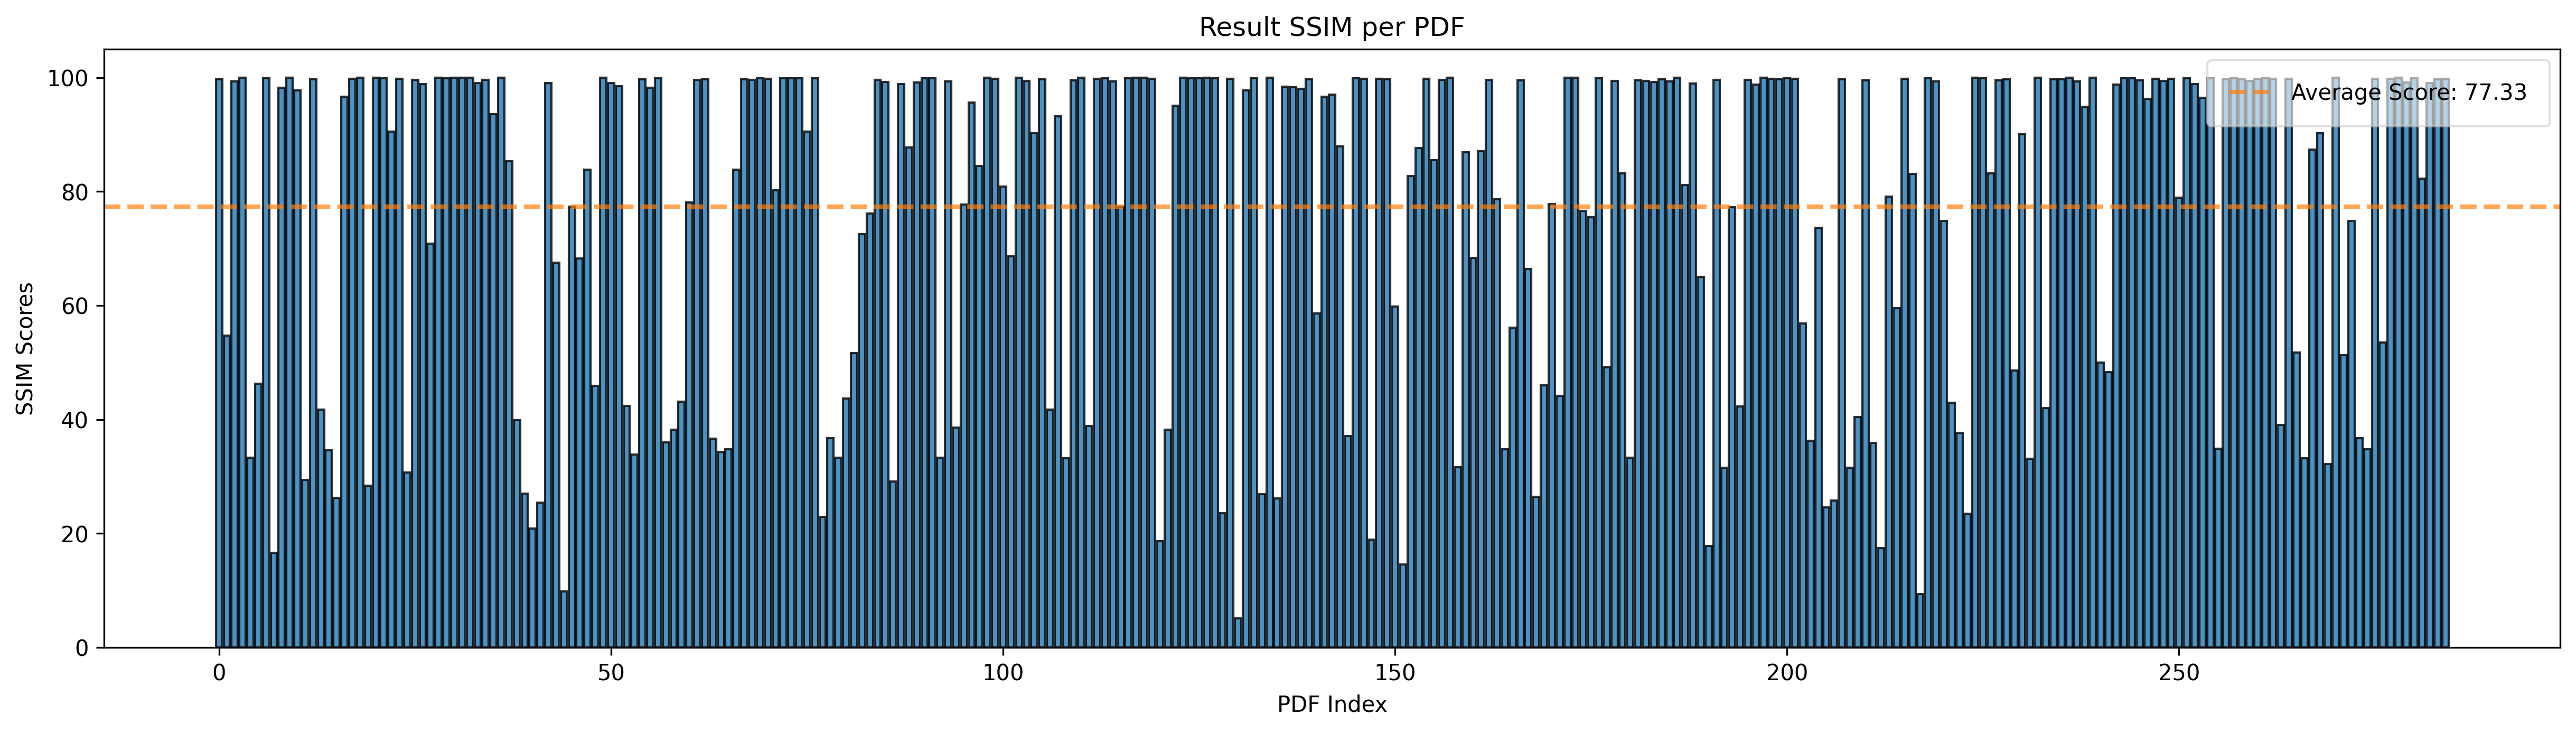

Score: 77 +/- 29


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
means = [pdf_scores[pdf]['mean_ssim'] for pdf in pdf_scores.keys()]
y = np.array(means)
x = np.arange(len(means))

plt.figure(figsize=(20,5),dpi=300)
# plt.hist(y, bins=np.arange(0,100,1),facecolor='#266DD3',edgecolor='black')
plt.axhline(y.mean(), color=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed', linewidth=2,label=f'Average Score: {y.mean():.2f}', alpha=0.7)
plt.bar(x, means, color=mcolors.TABLEAU_COLORS['tab:blue'],edgecolor='black', alpha=0.8)
# plt.scatter(x,means)
plt.title("Result SSIM per PDF")
plt.xlabel('PDF Index')
plt.ylabel("SSIM Scores")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)

plt.show()

print(f"Score: {y.mean():.0f} +/- {y.std():.0f}")

## Evaluating number of hits

## Image Recall 

In [7]:
# Total number of images
nfigs = 0
for key in pdf_scores.keys():
    for fig in pdf_scores[key]:
        if type(pdf_scores[key][fig]) == dict:
            nfigs += 1
print( f'Total number of figures: {nfigs}')

Total number of figures: 1876


In [8]:
# Hits curve with different thresholds
hits = []
for chosen_score in np.linspace(0,1,num=100):
    hit = 0
    for key in pdf_scores.keys():
        for fig in pdf_scores[key]:
            if type(pdf_scores[key][fig]) == dict:
                score = float(pdf_scores[key][fig]['score'])
                if score > chosen_score:
                    hit+=1
    hits.append(hit)

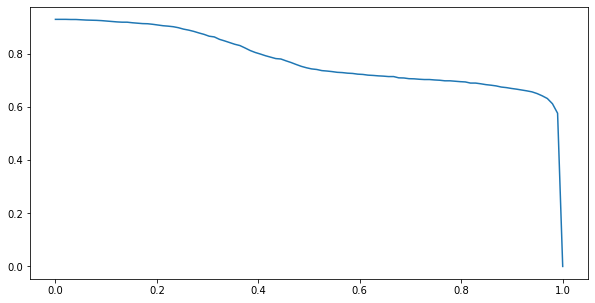

In [9]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,1,num=100), np.array(hits)/1876)
plt.show()

-- Chosen Threshold of 0.7

In [10]:
hit = 0
for key in pdf_scores.keys():
    for fig in pdf_scores[key]:
        if type(pdf_scores[key][fig]) == dict:
            score = float(pdf_scores[key][fig]['score'])
            if score > 0.7:
                hit+=1

In [11]:
result = hit / nfigs 
print(f"Image Recall (SSIM >=0.7) = {result:.02f}")

Image Recall (SSIM >=0.7) = 0.71
